# Why GPflux is a modern (deep) GP library

In this notebook we go over some of the features that make GPflux a powerful, deep-learning-style GP library. We demonstrate the out-of-the-box support for monitoring during the course of optimisation, adapting the learning rate, and saving & serving (deep) GP models.

## Setting up the dataset and model

### Motorcycle: a toy one-dimensional dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

tf.keras.backend.set_floatx("float64")  # we want to carry out GP calculations in 64 bit
tf.get_logger().setLevel("INFO")

2022-02-02 17:07:41.310428: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.12/x64/lib
2022-02-02 17:07:41.310462: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Text(0, 0.5, 'Acceleration')

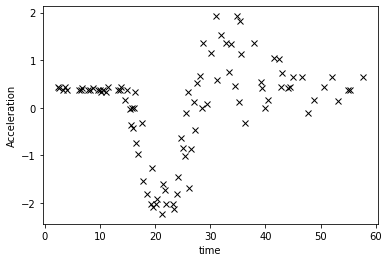

In [2]:
def motorcycle_data():
    """
    The motorcycle dataset where the targets are normalised to zero mean and unit variance.
    Returns a tuple of input features with shape [N, 1] and corresponding targets with shape [N, 1].
    """
    df = pd.read_csv("./data/motor.csv", index_col=0)
    X, Y = df["times"].values.reshape(-1, 1), df["accel"].values.reshape(-1, 1)
    Y = (Y - Y.mean()) / Y.std()
    return X, Y


X, Y = motorcycle_data()
plt.plot(X, Y, "kx")
plt.xlabel("time")
plt.ylabel("Acceleration")

### Two-layer deep GP

To keep this notebook focussed we are going to use a predefined deep GP architecture `gpflux.architectures.build_constant_input_dim_deep_gp` for creating our simple two-layer model.

In [3]:
import gpflux

from gpflux.architectures import Config, build_constant_input_dim_deep_gp
from gpflux.models import DeepGP

config = Config(
    num_inducing=25, inner_layer_qsqrt_factor=1e-5, likelihood_noise_variance=1e-2, whiten=True
)
deep_gp: DeepGP = build_constant_input_dim_deep_gp(X, num_layers=2, config=config)

2022-02-02 17:07:42.913211: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.12/x64/lib
2022-02-02 17:07:42.913243: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-02 17:07:42.913261: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az238-437): /proc/driver/nvidia/version does not exist
2022-02-02 17:07:42.913508: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Training: mini-batching, callbacks, checkpoints and monitoring

When training a model, GPflux takes care of minibatching the dataset and accepts a range of callbacks that make it very simple to, for example, modify the learning rate or monitor the optimisation. 

In [4]:
# From the `DeepGP` model we instantiate a training model which is a `tf.keras.Model`
training_model: tf.keras.Model = deep_gp.as_training_model()

# Following the Keras procedure we need to compile and pass a optimizer,
# before fitting the model to data
training_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01))

callbacks = [
    # Create callback that reduces the learning rate every time the ELBO plateaus
    tf.keras.callbacks.ReduceLROnPlateau("loss", factor=0.95, patience=3, min_lr=1e-6, verbose=0),
    # Create a callback that writes logs (e.g., hyperparameters, KLs, etc.) to TensorBoard
    gpflux.callbacks.TensorBoard(),
    # Create a callback that saves the model's weights
    tf.keras.callbacks.ModelCheckpoint(filepath="ckpts/", save_weights_only=True, verbose=0),
]

history = training_model.fit(
    {"inputs": X, "targets": Y},
    batch_size=12,
    epochs=200,
    callbacks=callbacks,
    verbose=0,
)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2022-02-02 17:07:43.283510: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


2022-02-02 17:07:43.796819: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-02-02 17:07:43.796849: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-02-02 17:07:43.797080: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-02-02 17:07:43.844693: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-02 17:07:43.845132: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2793435000 Hz


2022-02-02 17:07:48.107372: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-02-02 17:07:48.107408: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-02-02 17:07:48.111462: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-02-02 17:07:48.114862: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-02-02 17:07:48.119867: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_02_02_17_07_48
2022-02-02 17:07:48.123479: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_02_02_17_07_48/fv-az238-437.trace.json.gz
2022-02-02 17:07:48.129755: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_02_02_17_07_48
2022-02-02 17:07:48.129845: I t

The call to fit() returns a `history` object that contains information like the loss and the learning rate over the course of optimisation.

Text(0, 0.5, 'Learning rate')

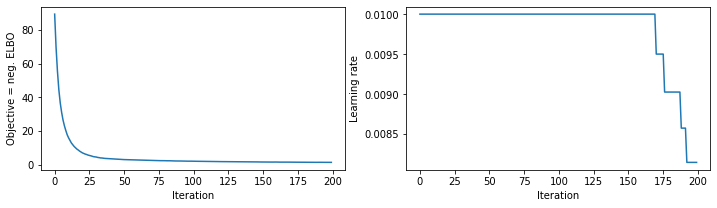

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
ax1.plot(history.history["loss"])
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Objective = neg. ELBO")

ax2.plot(history.history["lr"])
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Learning rate")

More insightful, however, are the TensorBoard logs. They contain the objective and hyperparameters over the course of optimisation. This can be very handy to find out why things work or don't :D. The logs can be viewed in TensorBoard by running in the command line
```
$ tensorboard --logdir logs
```

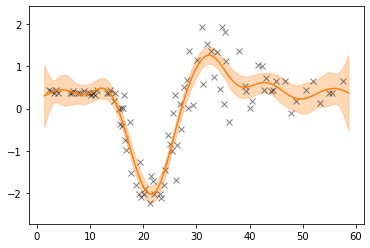

In [6]:
def plot(model, X, Y, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    x_margin = 1.0
    N_test = 100
    X_test = np.linspace(X.min() - x_margin, X.max() + x_margin, N_test).reshape(-1, 1)
    out = model(X_test)

    mu = out.f_mean.numpy().squeeze()
    var = out.f_var.numpy().squeeze()
    X_test = X_test.squeeze()
    lower = mu - 2 * np.sqrt(var)
    upper = mu + 2 * np.sqrt(var)

    ax.set_ylim(Y.min() - 0.5, Y.max() + 0.5)
    ax.plot(X, Y, "kx", alpha=0.5)
    ax.plot(X_test, mu, "C1")

    ax.fill_between(X_test, lower, upper, color="C1", alpha=0.3)


prediction_model = deep_gp.as_prediction_model()
plot(prediction_model, X, Y)

## Post-training: saving, loading, and serving the model

We can store the weights and reload them afterwards.

In [7]:
prediction_model.save_weights("weights")

In [8]:
prediction_model_new = build_constant_input_dim_deep_gp(
    X, num_layers=2, config=config
).as_prediction_model()
prediction_model_new.load_weights("weights")

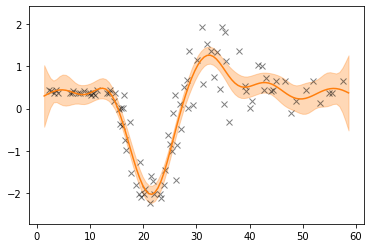

In [9]:
plot(prediction_model_new, X, Y)

Indeed, this prediction corresponds to the one of the original model.